In [7]:
import pandas as pd
import numpy as np

# Format misc
import json
import os
import pickle

# Plot
import seaborn as sns
import pylab as plt

# Scrape utils
import statsmodels.formula.api as smf
import grequests
import requests
import bs4 as bs

# Detect language
import sys
sys.path.append("./")

# Combine sets and calculate diversity
from scipy.stats import entropy
import itertools
from collections import Counter

import json
import requests
from urllib.parse import urlparse

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


%matplotlib inline

# Download main dataset (searches of people)

In [9]:
%%capture
# Download "google search results" dataset only if not previously downloaded to save time and bandwidth
files = [_ for _ in os.listdir("data") if "json" in _]
if not files:
    print("Data not found. Downloading. This can take about 15 minutes to complete.")
    !mkdir -p data
    for month in range(7, 10):
        month = "{:02.0f}".format(month)
        for day in range(1, 32):
            if (month == "07") & (day < 5):
                continue
            if (month == "09") & (day > 30):
                continue
            day = "{:02.0f}".format(day) 
            !wget -P data https://datenspende.algorithmwatch.org/btw17/download/public/datenspende_btw17_public_data_2017-"$month"-"$day".7z
            !7z x -odata data/datenspende_btw17_public_data_2017-"$month"-"$day".7z
            !rm data/datenspende_btw17_public_data_2017-"$month"-"$day".7z
else:
    print("Data already downloaded")

In [ ]:
# This step can take around 1 hour in a good laptop (32GB, i7)
def add_user(df, i):
    if int(len(df) / 16) != len(df) / 16:
        print(len(df), i)
        df["user"] = np.NaN #[date+_ for _ in sorted(list(range(int(len(df)/16)))*16)]
    else:
        df["user"] = [i + "_" + str(_) for _ in sorted(list(range(int(len(df)/16)))*16)]
    return df
    
# Format all the json files
files = [_ for _ in os.listdir("data") if "json" in _]
hash2links = dict()
print(len(files))
    
for i, file in enumerate(files):
    print(i, end=": ")
    date = file[-15:-5] + "_"
    d = json.load(open("data/"+file))
    for result in d[-1]:
        if hash2links.get(result["result_hash"]) is None:
            hash2links[result["result_hash"]] = set([_["sourceUrl"] for _ in result["result"]])
            
    df = pd.concat([add_user(pd.DataFrame(_), date + str(j)) for j,_ in enumerate(d[:-1])])
    df.to_csv("data/people_{}.tsv".format(file[:-5]), sep="\t", index=None)
#     df_hash = pd.DataFrame(d[-1])
#     df_hash.to_csv("data/hash_{}.tsv".format(file[:-5]),sep="\t",index=None)


In [ ]:
#Save
pickle.dump(hash2links, open("data_clean/hash2links.dump", "wb+"))

In [ ]:
#Go from postal code to constituency
const2postal = dict()
with open("data/const2postal.csv") as f:
    for line in f:
        try:
            a,b = line.split(":")
            const2postal[int(b.strip()[:-1])] = int(a.strip())
        except:
            pass #print(line)

In [ ]:
#Concat all csvs
files = [_ for _ in os.listdir("data") if "people_" in _]
people = pd.concat([pd.read_csv("data/" + file, sep="\t") for file in files])

people = people.loc[people["geo_location"].str.slice(0, 2) == "DE"]

people["geo_location2"] = people["geo_location"].str.split(" ").str[1]
people = people.loc[people["geo_location2"].str.len() > 1]
people = people.loc[people["search_date"] < "2017-09-24"]
people["const_i"] = people["geo_location2"].astype(int).map(const2postal)
print(people.loc[np.isnan(people["const_i"]), "geo_location2"].unique())
#['45403' '09060' '63405' '33311' '83739' '09039' '40832' '09202' '09359']

people = people.loc[~np.isnan(people["const_i"])]
people.head()

In [ ]:
people.to_csv("data_clean/all_people.csv",sep="\t",index=None)

# Create ideology from Twitter



In [ ]:
## The following code downloads 22,123,230 tweets and takes ~1 week (this is why it is commented out)
## To run it requires you to configure twarc correctly: https://medium.com/on-archivy/on-forgetting-e01a2b95272

#!mkdir data_social_media
#Download file ZA6926_data_v1-0-0.csv.zip from https://dbk.gesis.org/dbksearch/sdesc2.asp?no=6926
#!unzip data_social_media/ZA6926_data_v1-0-0.csv.zip data_social_media/

In [ ]:
# with open("data_social_media/tweets.json".format(j)) as f:
#     for i,line in enumerate(f):
#         pass
# max_i = (i+1)

# with open("data_social_media/twitter_IDs.utf-8.csv") as f,open("data_social_media/remaining_twitter_IDs.utf-8.csv","w+") as f2:
#     for i,line in enumerate(f):
#         if i < max_i:
#             pass
#         else:
#             f2.write(line)
            
# tweets_i += 1
# print(tweets_i)
# print(max_i)

# !twarc hydrate data_social_media/remaining_twitter_IDs.utf-8.csv > data_social_media/tweets1.json
# !cat data_social_media/tweets1.json >> data_social_media/tweets.json 
# !rm data_social_media/tweets1.json


# codebook = {1: "CDU",
# 2: "SPD",
# 3: "Linke",
# 4: "Grüne",
# 5: "CSU",
# 6: "FDP",
# 7: "AfD"}

# candidates = pd.read_csv("data_social_media/candidates.utf-8.csv",sep=",",usecols=["twlink","party"]).dropna()
# candidates["party"] = candidates["party"].map(codebook)

# def agg_tw(links):
#     return ":::".join([_.rsplit("/")[-1].lower() for _ in links])


# candidates["twlink"] = candidates["twlink"].str.split("/").str[-1].str.lower()
# orgs = pd.read_csv("data_social_media/twitter_organizations.utf-8.csv",sep=",").dropna()
# orgs = orgs.loc[orgs["group_or_party"]!="media"]
# orgs["screenName"] = orgs["screenName"].str.lower()
# candidates.columns = ["name","party"]
# orgs.columns = ["name","party"]
# cs = pd.concat([orgs,candidates])


# tw = set(cs["name"])
# c2party = cs.set_index("name").to_dict()["party"]


# with open("data_social_media/tweets.json") as f, open("data_clean/twitter_media.tsv","a+") as fout, open("data_clean/twitter_media_fail.tsv","a+") as ffail:
#     for i,line in enumerate(f):
#         if i < max_i:
#             continue
#         if i%100000 == 0:
#             print(i, end=": ")
#         try:
#             d = json.loads(line)
#         except:
#             pass

#         if d["user"]["screen_name"].lower() in tw:
#             id_,user = d["id"],d["user"]["screen_name"].lower()
#             try:
#                 s = "\t".join([str(id_),c2party[user],user,":::".join([requests.head(url["expanded_url"], allow_redirects=True).url for url in d["entities"]["urls"]])])
#                 fout.write(s+"\n")
#             except:
#                 ffail.write(line)
            

In [16]:

df = pd.read_csv("data_clean/twitter_media.tsv", sep="\t", header=None, names=["id", "party", "tw", "link"]).dropna()

df = df.loc[df["party"] != "Pegida"]
df["netloc"] = df["link"].apply(lambda x: urlparse(x).netloc.split(".")[-2])
df["count_netloc"] = df.groupby(["netloc"])["id"].transform(len)
df = df.loc[df["count_netloc"] > 10]
df["count"] = df.groupby(["party","netloc"])["id"].transform(len)
df["count_p"] = df.groupby(["party"])["id"].transform(len)
df = df.groupby(["party", "netloc", "count", "count_p"]).sum().reset_index()
df["ratio"] = df["count"] / df["count_p"]
df.head()

df["sum_netloc"] = df.groupby("netloc")["ratio"].transform(np.sum)
df["ideology"] = df["ratio"] / df["sum_netloc"]
del df["id"]

df2 = pd.pivot_table(df, values="ideology", index="netloc", columns="party").dropna(thresh=1)
#df2["div"] = df2.apply(lambda x: entropy(np.nan_to_num(x)+0.001),1)
#df2.sort_values(by="div",ascending=False)
df2.head()


display(np.round(df2.loc[["jungefreiheit","cicero","welt","bild","faz","zeit","taz","jungle","jungewelt"],["AfD","CSU","CDU","FDP","SPD","Grüne","Linke"]] * 100, 1).fillna(0))


df2["sqr"] = np.sqrt((df2>0).sum(1))
df2["std"] = df2[['AfD', 'CDU', 'CSU', 'FDP', 'Grüne', 'Linke', 'SPD']].std(1)
df2["std2"] = (df2["std"]*df2["sqr"]).fillna(1)

df2.sort_values(by="std2", ascending=False).tail(100).index

party,AfD,CSU,CDU,FDP,SPD,Grüne,Linke
netloc,,,,,,,
jungefreiheit,100.0,0.0,0.0,0.0,0.0,0.0,0.0
cicero,37.7,23.1,7.3,20.8,0.0,8.1,3.1
welt,32.2,14.0,20.1,17.4,7.8,5.1,3.3
bild,18.2,21.0,28.1,19.3,7.5,4.4,1.4
faz,13.7,18.5,24.7,22.9,5.5,10.1,4.6
zeit,6.6,4.0,13.6,11.9,17.7,29.8,16.5
taz,1.6,0.0,1.8,5.0,11.0,44.2,36.4
jungle,0.0,0.0,0.0,0.0,0.0,19.5,80.5
jungewelt,0.0,0.0,0.0,5.4,8.0,1.3,85.3


Index(['hessenschau', 'politico', 'focus', 'buzzfeed', 'vimeo', 'lobbycontrol',
       'instagram', 'frauenrat', 'weser-kurier', 'aerztezeitung',
       'sueddeutsche', 'shz', 'hr-inforadio', 'weforum', 'nytimes',
       'tagesschau', 'der-postillon', 'berliner-zeitung', 'daserste',
       'uebermedien', 'stuttgarter-zeitung', 'wn', 'welt', 'rundschau-online',
       'fr', 'diw', 'com', 'abendblatt', 'thueringen24', 'bloomberg', 'bild',
       'wahlnavi', 'swrmediathek', 'finanzen', 'rheinpfalz', 'mz-web', 'nw',
       'bento', 'lvz', 'dw', 'hamburg', 'nrz', 'blogspot', 'inforadio',
       't-online', 'mdr', 'huffingtonpost', 'jetzt', 'huffpost', 'derstandard',
       'volksfreund', 'handelsblatt', 'wahl-o-mat', 'bundeswahlleiter', 'zeit',
       'rnz', 'rbb-online', 'wz', 'wiwo', 'google', 'n-tv', 'web',
       'klimaretter', 'faz', 'swr', 'ft', 'swp', 'orf', 'tagesspiegel',
       'spiegel', 'bz-berlin', 'spotify', 'waz', 'hna', 'bbc',
       'goettinger-tageblatt', 'ksta', 'deutschl

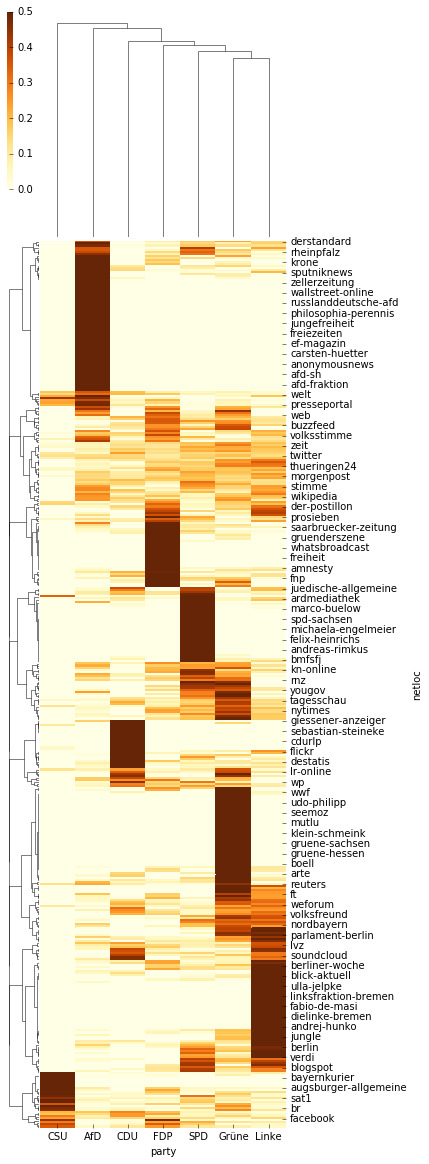

In [18]:
%matplotlib inline
import pylab as plt

sns.clustermap(df2[['AfD', 'CDU', 'CSU', 'FDP', 'Grüne', 'Linke', 'SPD']].fillna(0), method="complete", metric="cosine", figsize=(5, 20), cmap="YlOrBr", vmax=0.5)

In [19]:
import pickle
netloc2freqs= df2.fillna(0).apply(lambda x: [np.array(x)],axis=1).to_dict()
pickle.dump(netloc2freqs,open("data/netloc2freqs.dump", "wb+"))

# Clean data

In [21]:
hash2links = pickle.load(open("data_clean/hash2links.dump","rb+"))

In [22]:
people = pd.read_csv("data_clean/all_people.csv",sep="\t")
people["day"] = people["search_date"].str.split(" ").str[0]

/opt/anaconda/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
fix_keywords = {
    'Katrin%20G%C3%B6ring-Eckardt':'Katrin Göring-Eckardt',
    'Angela%20Merkel': 'Angela Merkel',
    'Christian%20Lindner': 'Christian Lindner',
    'Alexander%20Gauland': 'Alexander Gauland',
    'Die%20Linke': 'Die Linke', 
    'Sahra%20Wagenknecht': 'Sahra Wagenknecht',
    'Dietmar%20Bartsch': 'Dietmar Bartsch',
    'Martin%20Schulz': 'Martin Schulz', 
    'B%C3%BCndnis90/Die%20Gr%C3%BCnen':'Bündnis90/Die Grünen', 
    'Alice%20Weidel': 'Alice Weidel',
    'Cem%20%C3%96zdemir': 'Cem Özdemir',
    'Angelasdfsdfööööö Merkel': 'Angela Merkel',
    'Martinöööö Schulz': 'Martin Schulz'
}

people["keyword"] = people["keyword"].replace(fix_keywords)
people["keyword"].unique()

array(['Katrin Göring-Eckardt', 'Christian Lindner', 'FDP', 'AfD',
       'Alexander Gauland', 'Martin Schulz', 'SPD', 'Sahra Wagenknecht',
       'Alice Weidel', 'CDU', 'Die Linke', 'CSU', 'Angela Merkel',
       'Dietmar Bartsch', 'Cem Özdemir', 'Bündnis90/Die Grünen'],
      dtype=object)

In [24]:
person2party = {
    'Katrin Göring-Eckardt':'Bündnis90/Die Grünen',
    'Christian Lindner':'FDP',
    'Alexander Gauland': 'AfD',
    'Martin Schulz': 'SPD', 
    'Sahra Wagenknecht': 'Die Linke',
    'Angela Merkel': 'CDU',
    'Alice Weidel': 'AfD',
    'Dietmar Bartsch': 'Die Linke',
    'Cem Özdemir': 'Bündnis90/Die Grünen'
}


# Add ideology of results

In [25]:
netloc2freqs = pickle.load(open("data/netloc2freqs.dump", "rb+"))

In [27]:
#add average and std happiness
def get_ideology(x):
    hash_,keyword = x
    #All links hap
#     a,lo,le,nl,e = [],[],[],[],[]
    a = []
    for l in hash2links[hash_]:
        l = urlparse(l).netloc.split(".")
        if len(l) < 2:
            continue
        l = l[-2]
        lf = netloc2freqs.get(l)
        if lf is None:
            continue
        a.append(lf)

    if len(a) > 0:
        return np.nanmean(np.concatenate(a), 0), np.std(np.concatenate(a), 0), len(a)
    else:
        return np.array([np.NaN]*7), np.array([np.NaN]*7), len(a)

from multiprocessing import Pool

with Pool() as pool:
    people["av_ideo_all"], people["std_ideo_all"], people["count_ideo_all"] = zip(*pool.map(get_ideology, zip(people["result_hash"], people["keyword"])))


In [28]:
people["user2"] = people["user"] + "_" + people["login_status"].astype(int).astype(str)
p2i = {"AfD":0, "CDU":1, "CSU":2, "FDP":3, "Grüne":4, "Linke":5, "SPD":6}

for i in p2i:
    people["{}_ideo".format(i)] = people["av_ideo_all"].str[p2i[i]]
    people["{}_std_ideo".format(i)] = people["std_ideo_all"].str[p2i[i]]
    
del people["av_ideo_all"]
del people["std_ideo_all"]

parties = ['AfD', 'Bündnis90/Die Grünen', 'CDU', 'CSU', 'Die Linke','FDP', 'SPD']
people["person"] = people["keyword"].apply(lambda x: x in parties)

people.to_csv("data_clean/all_people_hap.csv", sep="\t", index=None)


# Entropy data

In [29]:
def mkunion(*args):
    args = [hash2links[_] for _ in args[0].values]
    all_links = list(Counter(list(itertools.chain(*args))).values())
    return entropy(all_links)/np.log(len(all_links))


In [30]:
p = people.groupby(["const_i","keyword","login_status","search_type","person"])
          .agg({"plugin_id":len, "result_hash":mkunion})
          .reset_index()
p["const_i"] = p["const_i"].astype(int)

p = p.loc[p["plugin_id"] > 1] # count of results
p["plugin_id"] = np.log10(p["plugin_id"])
p.to_csv("data_clean/all_people_entropy.csv", sep="\t", index=None)

/opt/anaconda/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
